In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt

from dotenv import load_dotenv
load_dotenv('../../azimuth.env')
import os
import sys
sys.path.append(os.environ['PATH_ROOT'])
print('PATH_ROOT:', os.environ['PATH_ROOT'], ' has been added to sys.path')

# Set the style for publication-quality plots
plt.style.use('seaborn-v0_8-paper')  # Clean, professional style
plt.rcParams.update({
    'font.family': 'serif',  # Use serif fonts
    'font.serif': ['Arial'],  # Use Times New Roman
    'font.size': 8,         # Readable font size
    'axes.linewidth': 1.0,   # Thicker axes lines
    'axes.labelsize': 8,    # Size for axis labels
    'xtick.labelsize': 8,    # Size for x-tick labels
    'ytick.labelsize': 8,    # Size for y-tick labels
})


PATH_ROOT: /Users/thinhhoang/Documents/alpha-azimuth/  has been added to sys.path


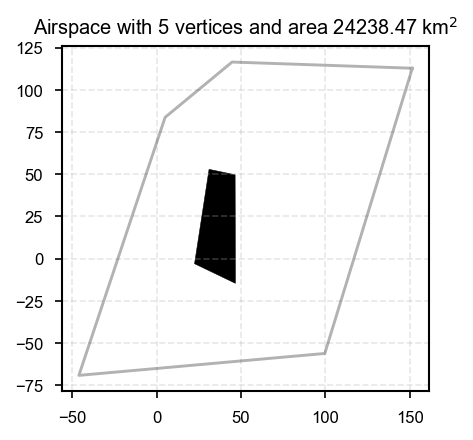

In [2]:
# Testing airspace radius sampling
import MARTINI.airspace.randomize_airspace as randomize_airspace
import MARTINI.airspace.geo as geo
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

# Generate a random airspace
airspace, area = randomize_airspace.generate_unit_polygon(5, 150)
# Get airspace centroid
centroid = geo.compute_polygon_centroid(airspace)
# Generate an obstacle
obstacle, area_obstacle = randomize_airspace.generate_unit_polygon(4, 35)
# Set the obstacle centroid to the airspace centroid
obstacle[:, 0] += centroid[0]
obstacle[:, 1] += centroid[1]

from ALPHA.obstacle.obstacle import Obstacle

obstacle_obj = Obstacle()
obstacle_obj.add_polygon(obstacle)

# Visualize the airspace
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.plot(np.append(airspace[:, 0], airspace[0, 0]), 
             np.append(airspace[:, 1], airspace[0, 1]), 
             alpha=0.3, color='black')

# Plot the obstacle
ax.fill(np.append(obstacle[:, 0], obstacle[0, 0]), 
             np.append(obstacle[:, 1], obstacle[0, 1]), 
             color='black')
ax.set_title(f'Airspace with {len(airspace)} vertices and area {area:.2f} km$^2$')
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

# Building a search tree

In [3]:
# Create a flight plan
from MARTINI.aircraft.flight_plan import FlightPlan
flight_plan = FlightPlan(waypoints=[airspace[3] * 1000, (0, 0), airspace[0] * 1000], altitudes=[10000, 10000, 10000], speeds=[250, 250, 250],
                         entry_time=0, entry_psi=0)
print(flight_plan)

Flight plan with 3 waypoints
* Waypoint 0: [-46004.65971903 -69208.99516734]
Altitude: 10000
Speed: 250
* Waypoint 1: [0. 0.]
Altitude: 10000
Speed: 250
* Waypoint 2: [151507.49092251 112721.89529166]
Altitude: 10000
Speed: 250


In [4]:
import ALPHA.treesearch.tree as tree

# Create a tree with flight plan as the state
my_tree = tree.Tree(root_state=flight_plan)


In [6]:
my_tree.evaluate_all_nodes(obstacle_obj, airspace)
print('Inherent cost of root:', my_tree.root.inherent_cost)

Inherent cost of root: 3114.473323816716


In [7]:
# Get actions for the root node
segment_idx, actions = my_tree.root.get_actions(obstacle_obj)
print('Segment index:', segment_idx)
print('Actions:', actions)

Segment index: 1
Actions: [[ 38.04651992 -13.0172203 ]
 [ 26.59528042  -5.61817899]
 [ 26.56640589  26.78009442]
 [ 28.69504189  41.66650523]
 [ 40.66142906 -13.78238988]
 [ 39.16435704  52.90397527]
 [ 26.84714419  26.99799438]
 [ 37.1595363   52.55140182]
 [ 22.84560215   3.30576298]
 [ 24.78495637  -7.31231325]
 [ 25.08582369  48.37848516]
 [ 48.19339121  47.28249667]
 [ 47.99676051  22.17662649]
 [ 26.52903547  41.67728919]
 [ 19.48316098  -2.23881017]
 [ 37.63564727 -11.43707391]
 [ 51.2755849   35.51449227]
 [ 25.67201186  37.25815937]
 [ 49.18419752  37.05474936]
 [ 46.55524174  52.88110932]
 [ 36.36912753  61.90226278]
 [ 49.42735647  33.70447531]
 [ 41.17855855 -15.07885119]
 [ 49.37924661 -14.52544264]
 [ 27.66271784  -6.09346814]
 [ 50.1256085   -4.17577047]
 [ 48.13568622  17.18113572]
 [ 21.89056399  -1.32796649]
 [ 49.31477617   2.78025611]
 [ 48.97812972   2.00694467]
 [ 26.00180595  -5.28633972]
 [ 52.10296232  22.30477917]
 [ 47.47396474  14.28784461]
 [ 55.71650401 -1

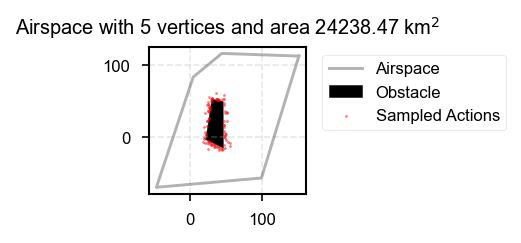

In [8]:
# Scatter plot the action
# Testing airspace radius sampling
import MARTINI.airspace.randomize_airspace as randomize_airspace
import MARTINI.airspace.geo as geo
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

# Visualize the airspace
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.plot(np.append(airspace[:, 0], airspace[0, 0]), 
             np.append(airspace[:, 1], airspace[0, 1]), 
             alpha=0.3, color='black')

# Plot the obstacle
ax.fill(np.append(obstacle[:, 0], obstacle[0, 0]), 
             np.append(obstacle[:, 1], obstacle[0, 1]), 
             color='black')

# Scatter plot the action
ax.scatter(actions[:, 0], actions[:, 1], color='red', s=1, alpha=0.5)
ax.set_title(f'Airspace with {len(airspace)} vertices and area {area:.2f} km$^2$')
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_aspect('equal')

# Add legend
ax.plot([], [], color='black', alpha=0.3, label='Airspace')
ax.fill([], [], color='black', label='Obstacle') 
ax.scatter([], [], color='red', s=1, alpha=0.5, label='Sampled Actions')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()

In [9]:
import copy

# Randomizing the action
for i in range(10):
    # Uniformly sample a point in the actions
    random_idx = np.random.randint(0, len(actions))
    print(f'Sampled action {i}:', actions[random_idx])
    # Add to the search tree
    # New state is the flight plan with the new waypoint
    flight_plan_new = copy.deepcopy(my_tree.root.state)
    # Insert the new waypoint at position segment_idx
    flight_plan_new.waypoints = np.insert(flight_plan_new.waypoints, segment_idx, actions[random_idx], axis=0)
    action_hash = '/'.join([str(segment_idx), str(actions[random_idx])])
    my_tree.root.add_child(action_hash, flight_plan_new, policy_category='obstacle')


Sampled action 0: [37.61948971 52.94240933]
Sampled action 1: [24.22330043 44.34348716]
Sampled action 2: [19.48316098 -2.23881017]
Sampled action 3: [29.8016828  50.51737343]
Sampled action 4: [47.07688025 58.40862014]
Sampled action 5: [36.36912753 61.90226278]
Sampled action 6: [ 35.15747188 -10.39669288]
Sampled action 7: [53.36448472 -6.24708043]
Sampled action 8: [39.10056531 51.19791546]
Sampled action 9: [39.10056531 51.19791546]


In [11]:
my_tree.evaluate_all_nodes(obstacle_obj, airspace)

In [13]:
my_tree.plot()

IndexError: index 3 is out of bounds for axis 0 with size 3